# Naive Model Building

In [243]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from edinburgh_challenge.constants import police_stations

In [244]:
source = "./data.xlsx"

In [245]:
data = pd.read_excel(source)

In [246]:
data.head()

,URN,Latitude,Longitude,Day,Hour,Priority,Deployment Time (hrs)
0,PS-20220706-0009,55.782705,-4.432785,1,0,Prompt,0.60
1,PS-20220706-0021,55.849990,-4.095880,1,0,Prompt,1.55
2,PS-20220706-0028,55.849864,-4.307251,1,0,Prompt,1.10
3,PS-20220706-0035,55.869998,-4.096223,1,0,Prompt,0.85
4,PS-20220706-0043,55.810980,-4.303656,1,0,Prompt,2.50


In [247]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2272 entries, 0 to 2271
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   URN                    2272 non-null   object 
 1   Latitude               2272 non-null   float64
 2   Longitude              2272 non-null   float64
 3   Day                    2272 non-null   int64  
 4   Hour                   2272 non-null   int64  
 5   Priority               2272 non-null   object 
 6   Deployment Time (hrs)  2272 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 124.4+ KB


In [248]:
# Masks
immediate_filter = data["Priority"] == "Immediate"
prompt_filter = data["Priority"] == "Prompt"
standard_filter = data["Priority"] == "Standard"

In [249]:
ps = [[f'PS_{i}', p.x, p.y] for i,p in 
      enumerate([police_stations.one, 
                 police_stations.two, 
                 police_stations.three])]
df_ps = pd.DataFrame(ps, columns=["Name","Latitude", "Longitude"])

## Initial EDA

### How many days?

In [250]:
print(f'Start Day: {data["Day"].max()} ')
print(f'Start Day: {data["Day"].min()} ')

Start Day: 7 
Start Day: 1 


### Where and When do these incidents take place?

In [251]:
data["Time"] = (data["Day"]-1)*24 + data["Hour"]

<Axes: xlabel='Latitude', ylabel='Longitude'>

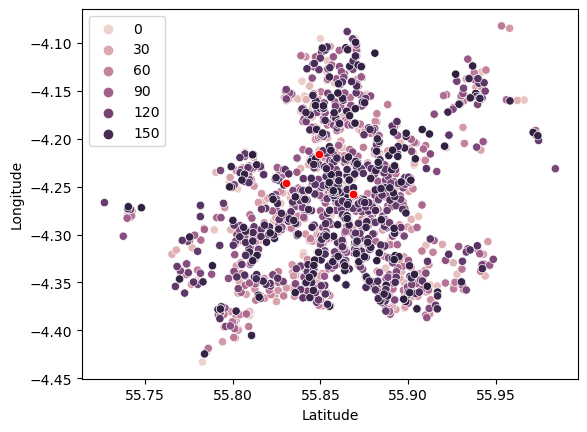

In [252]:
sns.scatterplot(data=data, x = "Latitude", y="Longitude", hue="Time")
sns.scatterplot(data=df_ps, x = "Latitude", y="Longitude", color="r")

Cannot really tell if there's a particular trend in where and when these events are taking place. However, I can see that there are a few places where the concentration of events is a bit higher than other places.

### What is the range on Deployment time? Is it different for different priorities?

In [253]:
print(f'Minimum deployment time: {data["Deployment Time (hrs)"].min()} hrs')
print(f'Maximum deployment time: {data["Deployment Time (hrs)"].max()} hrs')

Minimum deployment time: 0.5 hrs
Maximum deployment time: 2.5 hrs


In [254]:
print(f'Avg. deployment time for Immediate: {data[immediate_filter]["Deployment Time (hrs)"].mean()} hrs')
print(f'Avg. deployment time for Prompt: {data[prompt_filter]["Deployment Time (hrs)"].mean()} hrs')
print(f'Avg. deployment time for Standard: {data[standard_filter]["Deployment Time (hrs)"].mean()} hrs')

Avg. deployment time for Immediate: 1.5403225806451613 hrs
Avg. deployment time for Prompt: 1.5061196105702364 hrs
Avg. deployment time for Standard: 1.479675572519084 hrs


There seems to little difference between the mean deployment times of these different priorities. Let's have a look at their distributions to check if they have any impact at all.

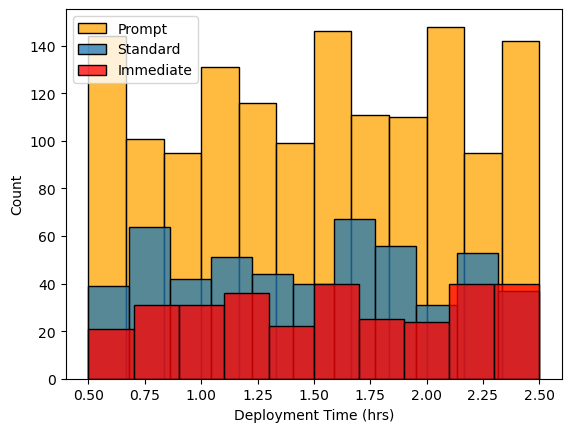

In [255]:
sns.histplot(data=data[prompt_filter], x="Deployment Time (hrs)", color="orange", label="Prompt")
sns.histplot(data=data[standard_filter], x="Deployment Time (hrs)", label="Standard")
sns.histplot(data=data[immediate_filter], x="Deployment Time (hrs)", color="red", label="Immediate")
plt.legend()

The deployment time seems arbitrary but has a fixed minimum of 0.5 hours and a fixed maximum of 2.5 hours. Hence, we can take this for granted (I think). However, it seems that Prompt is the most common type of event followed by standard and finally comes immediate.

### Does the priority and the location have any connection?

<Axes: xlabel='Latitude', ylabel='Longitude'>

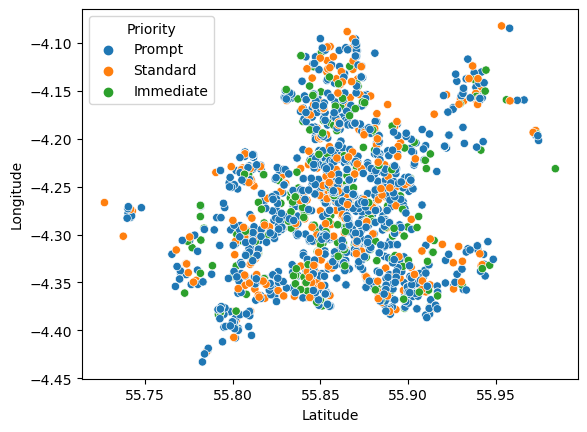

In [256]:
sns.scatterplot(data=data, x = "Latitude", y="Longitude", hue="Priority")

No, don't think so. Nothing apparent atleast. However, this information can be interest to feed into a Machine Learning model to fine tune it.

### Does the time of the day and the priority have any relation?

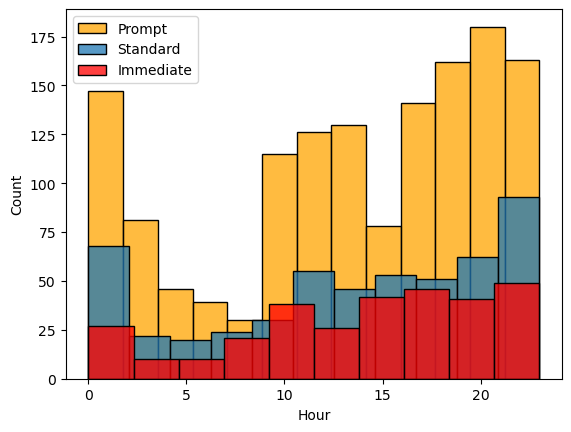

In [257]:
sns.histplot(data=data[prompt_filter], x="Hour", color="orange", label="Prompt")
sns.histplot(data=data[standard_filter], x="Hour", label="Standard")
sns.histplot(data=data[immediate_filter], x="Hour", color="red", label="Immediate")
plt.legend()

A general trend is that there are more incidents during the end of the day. The number of immediate incidents are also higher during this time of the day. This can be specified to the range 15-2.5 hours.Moreover, there is a sweet time from 2.5 to 10 hours of the day where the number of incidents is low. 

## Naive Model

In [16]:
# The Naive model assigns the closest available
# station's if officers available to resolve the issue

SyntaxError: unexpected EOF while parsing (2772972923.py, line 6)

## Simulation Building

In [176]:
from dataclasses import dataclass
from typing import List, Dict
import numpy as np
from abc import ABC, abstractmethod

class Model(ABC):
    @abstractmethod
    def make_allocation(self, incidents, officers, current_time):
        pass

@dataclass
class Incident:
    urn: str
    latitude: float
    longitude: float
    day:int
    hour:int
    global_time: float  # Time at which the incident was reported (24*day + hour)
    deployment_time: float  # Time taken to resolve the incident after reaching the location
    priority: str
    distances: Dict[str, float]  # Distances from each station
    resolved: bool = False
    resolving_officer: str = None
    response_time: float = None  # Global time when the response arrives at the scene
    resolution_time: float = None  # Global time when the incident is resolved

@dataclass
class Officer:
    name: str
    station: str
    available: bool = True
    return_time: float = 0.0
        
from typing import Dict, List

# Shift distribution structure
# Example: {'Early': {'Station_1': 5, 'Station_2': 5, 'Station_3': 5}, ...}
ShiftDistribution = Dict[str, Dict[str, int]]


In [210]:
from math import radians, cos, sin, asin, sqrt

class Simulation:
    SPEED_MPH = 30  # Speed in miles per hour

    def __init__(self, df: pd.DataFrame, station_coords: List[tuple], shift_distribution: ShiftDistribution, verbose:bool=False):
        self.df = df.copy()
        self.station_coords = station_coords
        self.shift_distribution = shift_distribution
        self.current_time = 0
        self.officers = {station: [] for station in shift_distribution[next(iter(shift_distribution))]}
        self.verbose = verbose
        # Making the df compatible with data structures
        df.columns = [x.lower() for x in df.columns]

    def print_dashboard(self):
        print(f"\n--- Day {self.current_time // 24 + 1}, Hour {self.current_time % 24} ---")
        pending_cases = [inc for inc in self.cumulative_incidents if not inc.resolved and inc.global_time <= self.current_time]
        print(f"Pending Cases: {len(pending_cases)}")
        print("Pending Incident URNs:", [inc.urn for inc in pending_cases])

        for station, officers in self.officers.items():
            print(f"\n{station}:")
            for officer in officers:
                # Find the incident the officer is currently assigned to
                current_incident = next((inc for inc in pending_cases if inc.resolving_officer == officer.name), None)
                status = current_incident.urn if current_incident else 'Free'
                print(f"  - {officer.name}: {status}")
        
    def calculate_distance(self, lat1, lon1, lat2, lon2):
        """
        Calculate the great circle distance between two points 
        on the earth (specified in decimal degrees)
        """
        # Convert decimal degrees to radians 
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

        # Haversine formula 
        dlat = lat2 - lat1 
        dlon = lon2 - lon1 
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a)) 
        r = 3956  # Radius of Earth in miles. Use 6371 for kilometers
        return c * r

    def generate_incidents_for_hour(self, day, hour):
        hour_incidents = self.df[(self.df['day'] == day) & (self.df['hour'] == hour)]
        incidents = []
        for _, row in hour_incidents.iterrows():
            global_time = 24 * (day - 1) + hour
            deployment_time = row.pop("deployment time (hrs)")
            row.pop("time")  # Not needed as we use global_time
            distances = {f'Station_{i+1}': self.calculate_distance(row['latitude'], row['longitude'], lat, lon) 
                         for i, (lat, lon) in enumerate(self.station_coords)}
            incidents.append(Incident(**row, 
                                      deployment_time=deployment_time, 
                                      distances=distances,
                                      global_time=global_time))
        return incidents


    def update_officers_for_shift(self, shift):
        for station, num_officers in self.shift_distribution[shift].items():
            
            # Update the number of officers for each station
            self.officers[station] = [Officer(f"Officer_{station}_{shift}_{i}", station=station) for i in range(num_officers)]

    def process_allocations(self, allocations):
        for urn, officer_id in allocations.items():
            incident = next((inc for inc in self.cumulative_incidents if inc.urn == urn), None)
            if officer_id is None:
                if incident:
                    incident.resolved = False
                continue

            officer = next((off for station_officers in self.officers.values() for off in station_officers if off.name == officer_id), None)
            if incident and officer:
                travel_time = incident.distances[officer.station] / self.SPEED_MPH
                officer.available = False  # Mark officer as busy
                officer.return_time = self.current_time + travel_time + incident.deployment_time
                incident.resolved = True  # Mark incident as resolved
                incident.resolving_officer = officer.name  # Assign officer to incident
                incident.response_time = self.current_time + travel_time
                incident.resolution_time = officer.return_time

                
    def update_officer_availability(self):
        for station, officers in self.officers.items():
            for officer in officers:
                if not officer.available and self.current_time >= officer.return_time:
                    officer.available = True


    def run(self, model):
        self.cumulative_incidents = []  # Global list to track all incidents

        while self.current_time < 24 * 7:  # For a week-long simulation
            day = self.current_time // 24 + 1
            hour = self.current_time % 24

            # Update officer availability at the start of each timestep
            self.update_officer_availability()

            # Update officers for shift change
            if hour in [0, 8, 16]:
                shift = 'Early' if hour == 0 else 'Day' if hour == 8 else 'Night'
                self.update_officers_for_shift(shift)

            # Generate and add new incidents
            new_incidents = self.generate_incidents_for_hour(day, hour)
            self.cumulative_incidents.extend(new_incidents)
            
            if self.verbose:
                self.print_dashboard()
            
            # Filter to get only pending incidents
            pending_incidents = [inc for inc in self.cumulative_incidents if not inc.resolved]

            # Call the model to allocate incidents
            allocations = model.make_allocation(pending_incidents, self.officers, self.current_time)

            # Process allocations and update the state
            self.process_allocations(allocations)

            
            self.current_time += 1  # Move to the next hour
            if self.verbose:
                input("Press Enter to continue to the next hour...\n")

In [211]:
class NaiveModel():
    def make_allocation(self, incidents, officers, current_time):
        # Sort incidents by priority
        incidents.sort(key=lambda inc: inc.priority)

        allocations = {}
        for inc in incidents:
            allocated = False
            # Sort stations by distance to the incident
            sorted_stations = sorted(inc.distances, key=inc.distances.get)

            for station in sorted_stations:
                # Check for available officer in the station
                available_officers = [off for off in officers[station] if off.available]
                if available_officers:
                    # Allocate the first available officer
                    chosen_officer = available_officers[0]
                    allocations[inc.urn] = chosen_officer.name
                    allocated = True
                    break
            
            if not allocated:
                # No officers available for this incident
                allocations[inc.urn] = None

        return allocations


In [212]:
shift_distribution = {
    'Early': {'Station_1': 5, 'Station_2': 5, 'Station_3': 5},
    'Day': {'Station_1': 8, 'Station_2': 8, 'Station_3': 9},
    'Night': {'Station_1': 13, 'Station_2': 13, 'Station_3': 14}
}

ps_coords = [ (p.x, p.y) for p in 
                [police_stations.one, 
                 police_stations.two, 
                 police_stations.three]]
num_officers_per_station = [4, 5, 6]
simulation = Simulation(data, ps_coords, shift_distribution, 
                        verbose=True)

In [213]:
naive_model = NaiveModel()

In [214]:
simulation.run(naive_model)


--- Day 1, Hour 0 ---
Pending Cases: 30
Pending Incident URNs: ['PS-20220706-0009', 'PS-20220706-0021', 'PS-20220706-0028', 'PS-20220706-0035', 'PS-20220706-0043', 'PS-20220706-0054', 'PS-20220706-0091', 'PS-20220706-0092', 'PS-20220709-0465', 'PS-20220709-0467', 'PS-20220709-0475', 'PS-20220709-0490', 'PS-20220709-0493', 'PS-20220709-0496', 'PS-20220709-0502', 'PS-20220709-0527', 'PS-20220709-0540', 'PS-20220709-0541', 'PS-20220709-0544', 'PS-20220711-0538', 'PS-20220711-0540', 'PS-20220711-0546', 'PS-20220711-0547', 'PS-20220711-0563', 'PS-20220711-0568', 'PS-20220711-0588', 'PS-20220711-0589', 'PS-20220711-0592', 'PS-20220711-0606', 'PS-20220711-0645']

Station_1:
  - Officer_Station_1_Early_0: Free
  - Officer_Station_1_Early_1: Free
  - Officer_Station_1_Early_2: Free
  - Officer_Station_1_Early_3: Free
  - Officer_Station_1_Early_4: Free

Station_2:
  - Officer_Station_2_Early_0: Free
  - Officer_Station_2_Early_1: Free
  - Officer_Station_2_Early_2: Free
  - Officer_Station_2_E

KeyboardInterrupt: Interrupted by user

In [182]:
simulation.cumulative_incidents

[Incident(urn='PS-20220706-0009', latitude=55.782705, longitude=-4.432785, day=1, hour=0, global_time=0, deployment_time=0.6, priority='Prompt', distances={'Station_1': 9.012235829616408, 'Station_2': 9.565104156903644, 'Station_3': 7.925008858475733}, resolved=True, resolving_officer='Officer_Station_3_Early_0', response_time=0.2641669619491911, resolution_time=0.8641669619491911),
 Incident(urn='PS-20220706-0021', latitude=55.84999, longitude=-4.0958801, day=1, hour=0, global_time=0, deployment_time=1.55, priority='Prompt', distances={'Station_1': 6.4132289010192345, 'Station_2': 4.673630821816955, 'Station_3': 6.009972287336082}, resolved=True, resolving_officer='Officer_Station_2_Early_0', response_time=0.15578769406056517, resolution_time=1.7057876940605652),
 Incident(urn='PS-20220706-0028', latitude=55.849864, longitude=-4.3072509, day=1, hour=0, global_time=0, deployment_time=1.1, priority='Prompt', distances={'Station_1': 2.3102373589545477, 'Station_2': 3.519719209056859, 'St

In [192]:
for i in simulation.cumulative_incidents:
    print(i.global_time, i.response_time, i.priority)

0 0.2641669619491911 Prompt
0 0.15578769406056517 Prompt
0 0.0770079119651516 Prompt
0 0.16252280325886856 Prompt
0 0.0857279340963862 Prompt
0 0.029240929591072065 Prompt
0 0.020952451393788755 Prompt
0 0.06640458105124132 Prompt
0 0.027213320469356792 Prompt
0 0.07928315624796597 Prompt
0 0.08141140272367815 Immediate
0 0.052177790700207775 Standard
0 0.008193396484618096 Prompt
0 0.021361639874228736 Prompt
0 0.002861675064041846 Prompt
0 0.09788408038797476 Prompt
0 0.04134031138007765 Prompt
0 0.060474253913544315 Standard
0 0.0615730886954455 Standard
0 0.10066941493798101 Prompt
0 0.05634707799650921 Immediate
0 0.18433112981481856 Prompt
0 0.0706598364826125 Prompt
0 0.05953594033868885 Prompt
0 0.10066941493798101 Immediate
0 0.10376692867462435 Prompt
0 0.06348312029835729 Prompt
0 0.0012043698395549105 Prompt
0 0.1155020214269651 Prompt
0 0.11811495303353538 Prompt
1 1.2048558265664073 Prompt
1 1.0273423966684172 Prompt
1 1.0192732452260609 Standard
1 1.012286933268723 Promp

In [184]:
def analyze_simulation_results(simulation):
    # Initialize counters and accumulators
    incident_counts = {'Immediate': 0, 'Prompt': 0, 'Standard': 0}
    resolved_counts = {'Immediate': 0, 'Prompt': 0, 'Standard': 0}
    within_threshold_counts = {'Immediate': 0, 'Prompt': 0, 'Standard': 0}
    response_times = {'Immediate': [], 'Prompt': [], 'Standard': []}
    resolution_times = {'Immediate': [], 'Prompt': [], 'Standard': []}
    deployment_times = {'Immediate': [], 'Prompt': [], 'Standard': []}
    thresholds = {'Immediate': 1, 'Prompt': 3, 'Standard': 6}
    total_officer_hours = {officer.name: 0 for station in simulation.officers.values() for officer in station}
    unresolved_incidents = 0

    # Analyze each incident
    for incident in simulation.cumulative_incidents:
        priority = incident.priority
        incident_counts[priority] += 1

        if incident.resolved:
            resolved_counts[priority] += 1
            
            response_time = incident.response_time
            resolution_time = incident.resolution_time
            
            response_times[priority].append(response_time)
            resolution_times[priority].append(resolution_time)
            
            deployment_time = incident.deployment_time
            deployment_times[priority].append(deployment_time)
            
            # Calculate the time from incident report to response arrival
            time_to_response = incident.response_time - incident.global_time


            # Check if the response was within the threshold
            if time_to_response <= thresholds[priority]:
                within_threshold_counts[priority] += 1
        else:
            unresolved_incidents += 1

    # Calculate percentages and mean times
    completion_percentages = {p: (resolved_counts[p] / incident_counts[p]) * 100 if incident_counts[p] > 0 else 0 for p in incident_counts}
    mean_response_times = {p: np.mean(response_times[p]) if response_times[p] else 0 for p in response_times}
    mean_deployment_times = {p: np.mean(deployment_times[p]) if deployment_times[p] else 0 for p in deployment_times}
    threshold_compliance = {p: (within_threshold_counts[p] / resolved_counts[p]) * 100 if resolved_counts[p] > 0 else 0 for p in incident_counts}

    # Calculate officer utilization
    for station in simulation.officers.values():
        for officer in station:
            if not officer.available:
                total_officer_hours[officer.name] += (simulation.current_time - officer.return_time)
    officer_utilization = sum(total_officer_hours.values()) / (len(total_officer_hours) * simulation.current_time) * 100

    unresolved_incident_percentage = (unresolved_incidents / len(simulation.cumulative_incidents)) * 100 if simulation.cumulative_incidents else 0

    return {
        "Completion Percentages": completion_percentages,
        "Mean Response Times": mean_response_times,
        "Mean Deployment Times": mean_deployment_times,
        "Threshold Compliance": threshold_compliance,
        "Officer Utilization": officer_utilization,
        "Unresolved Incident Percentage": unresolved_incident_percentage
    }

# Run analysis on the simulation results
simulation_metrics = analyze_simulation_results(simulation)

# Display the metrics
simulation_metrics


{'Completion Percentages': {'Immediate': 100.0,
  'Prompt': 100.0,
  'Standard': 100.0},
 'Mean Response Times': {'Immediate': 88.30562757834922,
  'Prompt': 84.38722006185152,
  'Standard': 87.58523466580172},
 'Mean Deployment Times': {'Immediate': 1.5403225806451613,
  'Prompt': 1.5061196105702366,
  'Standard': 1.4796755725190842},
 'Threshold Compliance': {'Immediate': 100.0,
  'Prompt': 100.0,
  'Standard': 100.0},
 'Officer Utilization': -0.04619104915929545,
 'Unresolved Incident Percentage': 0.0}

In [185]:
def check_simulation(simulation):
    # Initialize officer assignments based on all shifts
    officer_assignments = {}
    for shift, stations in shift_distribution.items():
        for station, num_officers in stations.items():
            for i in range(num_officers):
                officer_name = f"Officer_{station}_{shift}_{i}"
                officer_assignments[officer_name] = []
    
    incident_response = {'Immediate': {'total': 0, 'within_time': 0}, 
                         'Prompt': {'total': 0, 'within_time': 0}, 
                         'Standard': {'total': 0, 'within_time': 0}}
    
    time_travel_occurred = False

    for incident in simulation.cumulative_incidents:
        if incident.resolved:
            # Check officer assignments and time traveling
            if incident.resolving_officer:
                officer_assignments[incident.resolving_officer].append(incident.resolution_time)
                if len(officer_assignments[incident.resolving_officer]) > 1:
                    if officer_assignments[incident.resolving_officer][-2] > incident.resolution_time:
                        time_travel_occurred = True

            # Count incidents and check response time
            incident_response[incident.priority]['total'] += 1
            target_time = {'Immediate': 1, 'Prompt': 3, 'Standard': 6}[incident.priority]
            if incident.response_time <= target_time:
                incident_response[incident.priority]['within_time'] += 1

    # Calculate percentages
    for priority in incident_response:
        total = incident_response[priority]['total']
        if total > 0:
            incident_response[priority]['percentage'] = (incident_response[priority]['within_time'] / total) * 100
        else:
            incident_response[priority]['percentage'] = 0

    return officer_assignments, incident_response, time_travel_occurred

officer_assignments, incident_response, time_travel_occurred = check_simulation(simulation)

(officer_assignments, incident_response, time_travel_occurred)


({'Officer_Station_1_Early_0': [1.1770079119651518,
   1.4209524513937886,
   2.216404581051241,
   0.7772133204693568,
   2.431411402723678,
   1.5021777907002076,
   1.958193396484618,
   2.3213616398742287,
   2.4978840803879745,
   1.850669414937981,
   1.4063470779965093,
   0.8206598364826125,
   2.0095359403386888,
   1.400669414937981,
   0.651204369839555,
   4.198772642683924,
   6.632421585186329,
   5.890471292419646,
   7.484134072967909,
   5.526416765662478,
   8.309061669235124,
   8.029482076052945,
   8.213578829529217,
   8.162339630212735,
   7.9207710277921315,
   26.340552165325242,
   24.69946715559873,
   26.45684416943933,
   24.897997187128375,
   25.622046574912435,
   26.24635706081028,
   26.503357785066402,
   26.549770425939496,
   25.13323929386609,
   28.0776687500413,
   26.772691522996478,
   27.78720421300889,
   27.075466189928395,
   27.730052731281866,
   30.196111955881516,
   28.7073116253087,
   30.108361739381387,
   30.98515378961774,
   31.1

In [149]:
simulation.cumulative_incidents

[Incident(urn='PS-20220706-0009', latitude=55.782705, longitude=-4.432785, deployment_time=0.6, priority='Prompt', hour=0, day=1, distances={'Station_1': 9.012235829616408, 'Station_2': 9.565104156903644, 'Station_3': 7.925008858475733}, resolved=True, resolving_officer='Officer_Station_3_Early_0', response_time=0.2641669619491911, resolution_time=0.8641669619491911),
 Incident(urn='PS-20220706-0021', latitude=55.84999, longitude=-4.0958801, deployment_time=1.55, priority='Prompt', hour=0, day=1, distances={'Station_1': 6.4132289010192345, 'Station_2': 4.673630821816955, 'Station_3': 6.009972287336082}, resolved=True, resolving_officer='Officer_Station_2_Early_0', response_time=0.15578769406056517, resolution_time=1.7057876940605652),
 Incident(urn='PS-20220706-0028', latitude=55.849864, longitude=-4.3072509, deployment_time=1.1, priority='Prompt', hour=0, day=1, distances={'Station_1': 2.3102373589545477, 'Station_2': 3.519719209056859, 'Station_3': 2.7087317578072447}, resolved=True,

In [196]:
def replay_simulation(simulation):
    for hour in range(24 * 7):
        day = hour // 24 + 1
        current_hour = hour % 24
        print(f"Day {day}, Hour {current_hour}:")

        # Count pending cases
        pending_cases = [inc for inc in simulation.cumulative_incidents if not inc.resolved and inc.global_time <= hour]
        print(f"Pending Cases: {len(pending_cases)}")

        # Display officer status
        officer_status = {}
        for station, officers in simulation.officers.items():
            officer_status[station] = []
            for officer in officers:
                # Find the incident the officer is currently assigned to
                current_incident = next((inc for inc in simulation.cumulative_incidents if inc.resolving_officer == officer.name and inc.global_time <= hour and not inc.resolved), None)
                status = current_incident.urn if current_incident else 'Free'
                officer_status[station].append(f"{officer.name}: {status}")

        # Print officer status
        for station, statuses in officer_status.items():
            print(f"\n{station}:")
            for status in statuses:
                print(f"  - {status}")

        input("Press Enter to continue to the next hour...\n")

# Run the replay function
replay_simulation(simulation)


Day 1, Hour 0:
Pending Cases: 0

Station_1:
  - Officer_Station_1_Night_0: Free
  - Officer_Station_1_Night_1: Free
  - Officer_Station_1_Night_2: Free
  - Officer_Station_1_Night_3: Free
  - Officer_Station_1_Night_4: Free
  - Officer_Station_1_Night_5: Free
  - Officer_Station_1_Night_6: Free
  - Officer_Station_1_Night_7: Free
  - Officer_Station_1_Night_8: Free
  - Officer_Station_1_Night_9: Free
  - Officer_Station_1_Night_10: Free
  - Officer_Station_1_Night_11: Free
  - Officer_Station_1_Night_12: Free

Station_2:
  - Officer_Station_2_Night_0: Free
  - Officer_Station_2_Night_1: Free
  - Officer_Station_2_Night_2: Free
  - Officer_Station_2_Night_3: Free
  - Officer_Station_2_Night_4: Free
  - Officer_Station_2_Night_5: Free
  - Officer_Station_2_Night_6: Free
  - Officer_Station_2_Night_7: Free
  - Officer_Station_2_Night_8: Free
  - Officer_Station_2_Night_9: Free
  - Officer_Station_2_Night_10: Free
  - Officer_Station_2_Night_11: Free
  - Officer_Station_2_Night_12: Free

S

KeyboardInterrupt: Interrupted by user

In [194]:
simulation.cumulative_incidents


[Incident(urn='PS-20220706-0009', latitude=55.782705, longitude=-4.432785, day=1, hour=0, global_time=0, deployment_time=0.6, priority='Prompt', distances={'Station_1': 9.012235829616408, 'Station_2': 9.565104156903644, 'Station_3': 7.925008858475733}, resolved=True, resolving_officer='Officer_Station_3_Early_0', response_time=0.2641669619491911, resolution_time=0.8641669619491911),
 Incident(urn='PS-20220706-0021', latitude=55.84999, longitude=-4.0958801, day=1, hour=0, global_time=0, deployment_time=1.55, priority='Prompt', distances={'Station_1': 6.4132289010192345, 'Station_2': 4.673630821816955, 'Station_3': 6.009972287336082}, resolved=True, resolving_officer='Officer_Station_2_Early_0', response_time=0.15578769406056517, resolution_time=1.7057876940605652),
 Incident(urn='PS-20220706-0028', latitude=55.849864, longitude=-4.3072509, day=1, hour=0, global_time=0, deployment_time=1.1, priority='Prompt', distances={'Station_1': 2.3102373589545477, 'Station_2': 3.519719209056859, 'St

### Iteration 2

In [215]:
from dataclasses import dataclass
from typing import List, Dict
import numpy as np
from abc import ABC, abstractmethod

class Model(ABC):
    @abstractmethod
    def make_allocation(self, incidents, officers, current_time):
        pass

@dataclass
class Incident:
    urn: str
    latitude: float
    longitude: float
    day:int
    hour:int
    global_time: float  # Time at which the incident was reported (24*day + hour)
    deployment_time: float  # Time taken to resolve the incident after reaching the location
    priority: str
    distances: Dict[str, float]  # Distances from each station
    resolved: bool = False
    resolving_officer: str = None
    response_time: float = None  # Global time when the response arrives at the scene
    resolution_time: float = None  # Global time when the incident is resolved

@dataclass
class Officer:
    name: str
    station: str
    available: bool = True
    return_time: float = 0.0
        
from typing import Dict, List

# Shift distribution structure
# Example: {'Early': {'Station_1': 5, 'Station_2': 5, 'Station_3': 5}, ...}
ShiftDistribution = Dict[str, Dict[str, int]]


In [324]:
from math import radians, cos, sin, asin, sqrt

class Simulation:
    SPEED_MPH = 30  # Speed in miles per hour

    def __init__(self, df: pd.DataFrame, station_coords: List[tuple], shift_distribution: ShiftDistribution, verbose:bool=False):
        self.df = df.copy()
        self.station_coords = station_coords
        self.shift_distribution = shift_distribution
        self.current_time = 0
        self.officers = { key: [] for key in shift_distribution["Early"].keys() } # Station_1, Station_2 and Station_3
        self.verbose = verbose
        # Making the df compatible with data structures
        df.columns = [x.lower() for x in df.columns]

    def print_dashboard(self):
        print(f"\n--- Day {self.current_time // 24 + 1}, Hour {self.current_time % 24} ---")
        pending_cases = [inc for inc in self.cumulative_incidents if not inc.resolved]
        print(f"Pending Cases: {len(pending_cases)}")
        print("Pending Incident URNs:", [inc.urn for inc in pending_cases])

        for station, officers in self.officers.items():
            print(f"\n{station}:")
            for officer in officers:
                # Find the incident the officer is currently assigned to
                current_incident = next((inc for inc in pending_cases if inc.resolving_officer == officer.name), None)
                status = current_incident.urn if current_incident else 'Free'
                print(f"  - {officer.name}: {status}")
        
    def calculate_distance(self, lat1, lon1, lat2, lon2):
        """
        Calculate the great circle distance between two points 
        on the earth (specified in decimal degrees)
        """
        # Convert decimal degrees to radians 
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

        # Haversine formula 
        dlat = lat2 - lat1 
        dlon = lon2 - lon1 
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a)) 
        r = 3956  # Radius of Earth in miles. Use 6371 for kilometers
        return c * r

    def generate_incidents_for_hour(self, global_time):
        hour_incidents = self.df[(self.df['time'] == global_time)]
        incidents = []
        for _, row in hour_incidents.iterrows():
            deployment_time = row.pop("deployment time (hrs)")
            row.pop("time")  # Not needed as we use global_time
            distances = {f'Station_{i+1}': self.calculate_distance(row['latitude'], row['longitude'], lat, lon) 
                         for i, (lat, lon) in enumerate(self.station_coords)}
            incidents.append(Incident(**row, 
                                      deployment_time=deployment_time, 
                                      distances=distances,
                                      global_time=global_time))
        return incidents


    def update_officers_for_shift(self, shift):
        for station, num_officers in self.shift_distribution[shift].items():
            # Update the number of officers for each station
            self.officers[station] = [Officer(f"Officer_{station}_{shift}_{i}", station=station) for i in range(num_officers)]

    def process_allocations(self, allocations):
        for urn, officer_id in allocations.items():
            incident = next((inc for inc in self.cumulative_incidents if inc.urn == urn), None)
            #print("incident:", incident)
            if officer_id is None:
                if incident:
                    incident.resolved = False
                continue

            officer = next((off for station_officers in self.officers.values() for off in station_officers if off.name == officer_id), None)
            if incident and officer:
                travel_time = incident.distances[officer.station] / self.SPEED_MPH
                officer.available = False  # Mark officer as busy
                officer.return_time = self.current_time + travel_time + incident.deployment_time
                incident.resolved = True  # Mark incident as resolved
                incident.resolving_officer = officer.name  # Assign officer to incident
                incident.response_time = self.current_time + travel_time
                incident.resolution_time = officer.return_time

                
    def update_officer_availability(self):
        for station, officers in self.officers.items():
            for officer in officers:
                if not officer.available and self.current_time >= officer.return_time:
                    officer.available = True


    def run(self, model):
        self.cumulative_incidents = []  # Global list to track all incidents

        while self.current_time < 24 * 6:  # For a week-long simulation
            
            day = self.current_time // 24 + 1
            hour = self.current_time % 24
            
            # Update officer availability at the start of each timestep
            self.update_officer_availability()

            # Update officers for shift change
            if hour in [0, 8, 16]:
                shift = 'Early' if hour == 0 else 'Day' if hour == 8 else 'Night'
                print(f"{shift=}")
                self.update_officers_for_shift(shift)
            
            total_officers = len([ o for st in self.officers for o in st])
            print(f"{total_officers=}")
                
            # Generate and add new incidents
            new_incidents = self.generate_incidents_for_hour(self.current_time)
            self.cumulative_incidents.extend(new_incidents)
            
            if self.verbose:
                self.print_dashboard()
            
            # Filter to get only pending incidents
            pending_incidents = [inc for inc in self.cumulative_incidents if not inc.resolved]
            print(f"{len(pending_incidents)=}")
            # Call the model to allocate incidents
            allocations = model.make_allocation(pending_incidents, self.officers, self.current_time)

            # Process allocations and update the state
            self.process_allocations(allocations)

            
            self.current_time += 1  # Move to the next hour
            if self.verbose:
                input("Press Enter to continue to the next hour...\n")

In [325]:
simulation = Simulation(data, ps_coords, shift_distribution, 
                        verbose=False)

In [326]:
shift_distribution

{'Early': {'Station_1': 5, 'Station_2': 5, 'Station_3': 5},
 'Day': {'Station_1': 8, 'Station_2': 8, 'Station_3': 9},
 'Night': {'Station_1': 13, 'Station_2': 13, 'Station_3': 14}}

In [327]:
simulation.run(naive_model)

shift='Early'
total_officers=27
len(pending_incidents)=30
total_officers=27
len(pending_incidents)=20
total_officers=27
len(pending_incidents)=7
total_officers=27
len(pending_incidents)=5
total_officers=27
len(pending_incidents)=9
total_officers=27
len(pending_incidents)=6
total_officers=27
len(pending_incidents)=7
total_officers=27
len(pending_incidents)=5
shift='Day'
total_officers=27
len(pending_incidents)=7
total_officers=27
len(pending_incidents)=19
total_officers=27
len(pending_incidents)=17
total_officers=27
len(pending_incidents)=24
total_officers=27
len(pending_incidents)=18
total_officers=27
len(pending_incidents)=4
total_officers=27
len(pending_incidents)=3
total_officers=27
len(pending_incidents)=3
shift='Night'
total_officers=27
len(pending_incidents)=4
total_officers=27
len(pending_incidents)=9
total_officers=27
len(pending_incidents)=5
total_officers=27
len(pending_incidents)=3
total_officers=27
len(pending_incidents)=16
total_officers=27
len(pending_incidents)=41
total_

In [270]:
{station: [] for station in shift_distribution[next(iter(shift_distribution))]}

{'Station_1': [], 'Station_2': [], 'Station_3': []}

In [271]:
shift_distribution

{'Early': {'Station_1': 5, 'Station_2': 5, 'Station_3': 5},
 'Day': {'Station_1': 8, 'Station_2': 8, 'Station_3': 9},
 'Night': {'Station_1': 13, 'Station_2': 13, 'Station_3': 14}}

In [231]:
[i for i in shift_distribution[next(iter(shift_distribution))]]

['Station_1', 'Station_2', 'Station_3']

In [284]:
data[data["time"]==1].shape

(20, 8)